In [1]:
## Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from PyAstronomy.pyasl import foldAt
import warnings


## Optimize for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [2]:
strain_data = np.load('strain.npy')
time_minutes = np.arange(1, len(strain_data)+1)
time_days = time_minutes/1440
time_seconds = time_minutes*60
time_freq = np.arange(0, len(time_seconds)) * 1/60 * 1/len(time_seconds)

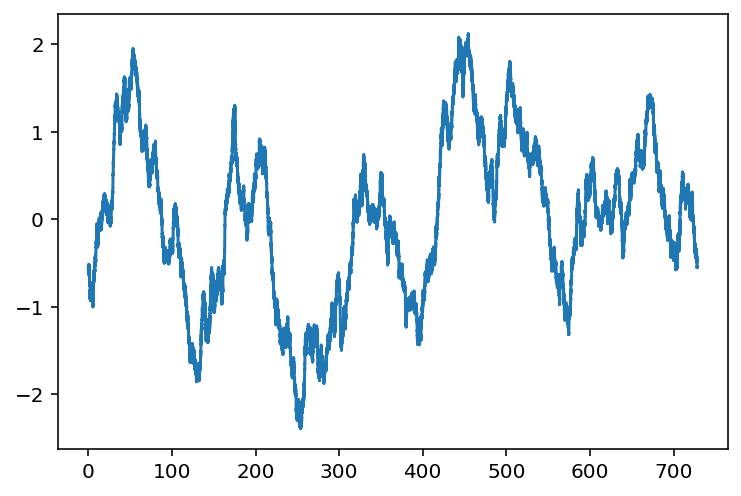

In [3]:
plt.plot(time_days,strain_data/(1e-18))

In [21]:
def FFT(x):
    N = len(x)

    N_min = min(N, 32)
    print(N_min)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

32


Text(0, 0.5, 'Amplitude Spectrum |$\\tilde{H}(f)$|')

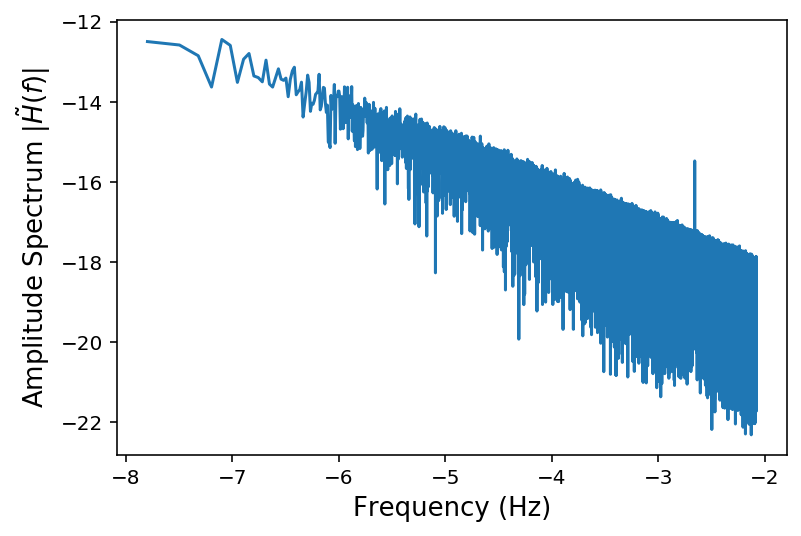

In [22]:
x_test = FFT(strain_data)
plt.plot(np.log10(time_freq[:int(len(x_test)*0.5)]),np.log10(x_test[:int(len(x_test)*0.5)]))
plt.xlabel('Frequency (Hz)',size=13)
plt.ylabel(r'Amplitude Spectrum |$\tilde{H}(f)$|',size=13)


In [7]:
np.argmax(x_test[int(len(x_test)*0.1):int(len(x_test)*0.5)])

33790

In [8]:
time_freq[int(len(x_test)*0.1)+33790]

0.0022037347157796224

In [9]:
np.log10(time_freq[int(len(x_test)*0.1)+33790])

-2.6568406867745678

In [11]:
len(time_freq)

1048576

In [12]:
np.sqrt(1048576)

1024.0